# Actividad evaluable del módulo 5: Completar frases mediante LSTM

Ahora que tenemos un marco para trabajar con datos secuenciales en PyTorch, nos centraremos en mejorar un modelo diseñado para completar frases. Para ello, introduciremos una codificación del conjunto de datos y una arquitectura de red neuronal más sofisticadas.

En esta actividad, deberá implementar un modelo LSTM que contenga 2 capas ocultas y que complete frases al nivel de codificación de palabras en vez de al nivel de caracteres. Le proporcionaremos el código necesario para limpiar y preparar los datos, así como algunas funciones de ayuda que le permitan completar la tarea.

## Conjunto de datos y codificación

Utilizaremos el mismo conjunto de datos, pero ahora los objetivos de la secuencia serán las frases en español.

In [15]:
from io import open
import unicodedata
import string
import random
import re

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import time, copy
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [16]:
# Descargar y descomprimir el archivo de texto que contiene las frases traducidas
!rm spa-eng.zip _about.txt spa.txt
!wget https://www.manythings.org/anki/spa-eng.zip
!unzip spa-eng.zip
!ls

--2023-02-01 17:30:46--  https://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5336731 (5.1M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   5.09M  11.7MB/s    in 0.4s    

2023-02-01 17:30:47 (11.7 MB/s) - ‘spa-eng.zip’ saved [5336731/5336731]

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 
_about.txt  sample_data  spa-eng.zip  spa.txt


In [17]:
# Funciones de ayuda combinadas del tutorial de PyTorch: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

# Convertir una string de Unicode a ASCII plano, gracias a
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Convertir los caracteres a minúsculas, recortar y eliminar todos los caracteres que no sean letras
# Este paso es importante para que todas las palabras tengan el mismo formato,
# igual que sucede al normalizar imágenes
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r"", s)
    s = re.sub(r"[^a-zA-Z.!'?]+", r" ", s)
    return s

def parse_data(filename):
    # Leer el archivo y dividir en líneas
    lines = open(filename, encoding='utf-8').read().strip().split('\n')

    # Dividir cada línea en pares y normalizar
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    # Eliminar la atribución, porque no forma parte de los datos
    pairs = [[pair[0], pair[1]] for pair in pairs]

    return pairs

In [18]:
pairs = parse_data("spa.txt")
# Solo nos interesan las frases en inglés, porque no vamos a traducir
english_sentences = [pair[0] for pair in pairs]
# Mezclar el conjunto de datos
random.shuffle(english_sentences)
print("Number of English sentences:", len(english_sentences))

Number of English sentences: 139013


In [19]:
# Como ya hemos mezclado el conjunto de datos, tomamos una muestra aleatoria de frases para los conjuntos de entrenamiento, validación y prueba
# Aquí, utilizamos un número pequeño de frases para reducir el tiempo de entrenamiento, pero puede usar más si lo desea 
train_sentences = english_sentences[:1000]
val_sentences = english_sentences[1000:2000]
test_sentences = english_sentences[2000:3000]

# Mediante esta función, crearemos un diccionario para utilizarlo con los vectores de codificación one-hot
def add_words_to_dict(word_dictionary, word_list, sentences):
    for sentence in sentences:
        for word in sentence.split(" "):
            if word in word_dictionary:
                continue
            else:
                word_list.append(word)
                word_dictionary[word] = len(word_list)-1

english_dictionary = {}
english_list = []
add_words_to_dict(english_dictionary, english_list, train_sentences)
add_words_to_dict(english_dictionary, english_list, val_sentences)
add_words_to_dict(english_dictionary, english_list, test_sentences)

len(english_dictionary)

2726

### Codificación

In [20]:
# Crear las muestras de entrenamiento
def create_input_tensor(sentence, word_dictionary):
    words = sentence.split(" ")
    tensor = torch.zeros(len(words), 1, len(word_dictionary)+1)
    for idx in range(len(words)):
        word = words[idx]
        tensor[idx][0][word_dictionary[word]] = 1
    return tensor

def create_target_tensor(sentence, word_dictionary):
    words = sentence.split(" ")
    tensor = torch.zeros(len(words), 1, len(word_dictionary)+1)
    for idx in range(1, len(words)):
        word = words[idx]
        tensor[idx-1][0][word_dictionary[word]] = 1
    tensor[len(words)-1][0][len(word_dictionary)] = 1 # EOS
    return tensor


train_tensors = [(create_input_tensor(sentence, english_dictionary), create_target_tensor(sentence, english_dictionary)) for sentence in train_sentences]
val_tensors = [(create_input_tensor(sentence, english_dictionary), create_target_tensor(sentence, english_dictionary)) for sentence in val_sentences]
test_tensors = [(create_input_tensor(sentence, english_dictionary), create_target_tensor(sentence, english_dictionary)) for sentence in test_sentences]

In [21]:
def tensor_to_sentence(word_list, tensor):
    sentence = ""
    for i in range(tensor.size(0)):
        topv, topi = tensor[i].topk(1)
        if topi[0][0] == len(word_list):
            sentence += "<EOS>"
            break
        sentence += word_list[topi[0][0]]
        sentence += " "
    return sentence

print("This code helps visualize what an input and it's corresponding target should look like!")
for input, target in train_tensors:
    print(tensor_to_sentence(english_list, input))
    print(tensor_to_sentence(english_list, target))
    break


This code helps visualize what an input and it's corresponding target should look like!
i can do that if you let me 
can do that if you let me <EOS>


In [22]:
dataloaders = {'train': train_tensors,
               'val': val_tensors,
               'test': test_tensors}

dataset_sizes = {'train': len(train_tensors),
                 'val': len(val_tensors),
                 'test': len(test_tensors)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 1000, 'val': 1000, 'test': 1000}


### Definición de la LSTM

Incluya su modelo en esta sección. La estructura básica ya está creada.


In [23]:
# Fuentes utilizadas para entender las LSTM y programar el modelo:
#   https://colah.github.io/posts/2015-08-Understanding-LSTMs/index.html
#   https://d2l.ai/chapter_recurrent-modern/lstm.html 
#   https://www.youtube.com/watch?v=ppJA9iyByNo 

class TwoLayerLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerLSTM, self).__init__()
        self.hidden_size = hidden_size

        # Primera capa LSTM
        self.fc_i_gates_1 = nn.Linear(input_size + hidden_size, hidden_size)
        self.fc_f_gates_1 = nn.Linear(input_size + hidden_size, hidden_size)
        self.fc_o_gates_1 = nn.Linear(input_size + hidden_size, hidden_size)
        self.fc_g_gates_1 = nn.Linear(input_size + hidden_size, hidden_size)

        # Segunda capa LSTM
        self.fc_i_gates_2 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_f_gates_2 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_o_gates_2 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_g_gates_2 = nn.Linear(hidden_size * 2, hidden_size)

        self.output_layer = nn.Linear(hidden_size, output_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def initHidden(self):
        # Modifique un poco la funcion initHidden, porque no sabia como usar los tensores con dimension (2, hidden_size) y estaba apurado a que funcionara
        return (torch.zeros(1, self.hidden_size).to(self.device), torch.zeros(1, self.hidden_size).to(self.device), torch.zeros(1, self.hidden_size).to(self.device), torch.zeros(1, self.hidden_size).to(self.device))


    def forward(self, input, hidden):
        (h_1, c_1, h_2, c_2) = hidden

        combined_1 = torch.cat((input, h_1), dim=1)

        # Calcular las compuertas forget, input, y cell state (candidato) para la LSTM 1
        forget_1 = torch.sigmoid(self.fc_f_gates_1(combined_1))
        input_1 = torch.sigmoid(self.fc_i_gates_1(combined_1))
        cell_state_1 = torch.tanh(self.fc_g_gates_1(combined_1))
        
        # Calcular la compuerta output para LSTM 1
        output_1 = torch.sigmoid(self.fc_o_gates_1(combined_1))
        
        # Calcular el nuevo valor de cell state para LSTM 1
        c_1 = forget_1 * c_1 + input_1 * cell_state_1
        
        # Calcular el hidden state para LSTM 1
        h_1 = output_1 * torch.tanh(c_1)
        
        combined_2 = torch.cat((h_1, h_2), dim=1)

        # Calcular las compuertas forget, input, y cell state (candidato) para la LSTM 2
        forget_2 = torch.sigmoid(self.fc_f_gates_2(combined_2))
        input_2 = torch.sigmoid(self.fc_i_gates_2(combined_2))
        cell_state_2 = torch.tanh(self.fc_g_gates_2(combined_2))
        
        # Calcular el nuevo valor de cell state para LSTM 2
        c_2 = forget_2 * c_2 + input_2 * cell_state_2
        
        # Calcular la compuerta output para LSTM 2
        output_2 = torch.sigmoid(self.fc_o_gates_2(combined_2))
        
        # Calcular el hidden state para LSTM 2
        h_2 = output_2 * torch.tanh(c_2)

        final_output = self.output_layer(h_2)

        # Retornar la salida y los estados ocultos.
        return (final_output, (h_1, c_1, h_2, c_2))


In [24]:
print(train_tensors[9][0][1].shape)
print(tensor_to_sentence(english_list, train_tensors[9][0]))

torch.Size([1, 2727])
are you waiting for someone 


In [25]:

# COMPLETAR
input_size = output_size = len(english_dictionary) + 1
hidden_size = 128
lstm = TwoLayerLSTM(input_size, hidden_size, output_size)

learning_rate = 0.0001
num_epochs = 10 # Solo vamos a aplicar 10 ciclos para ahorrar tiempo, pero puede utilizar más si quiere

criterion = nn.CrossEntropyLoss() # Utilizar CrossEntropyLoss para la clasificación.
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)


In [26]:
def train_lstm(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # Almacenar los mejores pesos por separado
    best_loss = np.inf
    best_epoch = 0

    # Cada ciclo tiene una fase de entrenamiento, validación y prueba
    phases = ['train', 'val', 'test']
    
    # Hacer un seguimiento de la evolución de la pérdida durante el entrenamiento
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Configurar el modelo en modo de entrenamiento
            else:
                model.eval()   # Configurar el modelo en modo de evaluación

            running_loss = 0.0

            # Iterar con los datos
            for input_sequence, target_sequence in dataloaders[phase]:
                # Ahora, iterar con cada secuencia

                hidden = model.initHidden() # Empezar con un estado oculto nuevo

                current_input_sequence = input_sequence.to(device)
                current_target_sequence = target_sequence.to(device)

                # Poner a cero los gradientes de los parámetros
                optimizer.zero_grad()

                # Método forward
                with torch.set_grad_enabled(phase == 'train'):
                    loss = 0
                    # Hacer una predicción de cada elemento de la secuencia
                    # y llevar un seguimiento del estado oculto a lo largo del proceso
                    for i in range(current_input_sequence.size(0)):
                        # Debemos pensar bien cómo transferir las capas ocultas al dispositivo
                        current_hidden = (hidden[0].to(device), hidden[1].to(device), hidden[2].to(device), hidden[3].to(device))
                        # print(current_hidden[0].shape, current_hidden[1].shape)
                        # print("input:", current_input_sequence[i].shape)
                        output, hidden = model(current_input_sequence[i], current_hidden)
                        # print("output:", output.shape)
                        # print("hidden:", hidden.shape)
                        l = criterion(output, current_target_sequence[i])
                        loss += l

                    # Método backward y actualización de los pesos solo si está en la fase de entrenamiento al final de una secuencia
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() / current_input_sequence.size(0)
 
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # Hacer una copia profunda del modelo si tenemos la mejor pérdida
            # Nota: utilizamos la pérdida de entrenamiento para seleccionar el mejor modelo
            if phase == 'train' and epoch_loss < best_loss:
              best_epoch = epoch
              best_loss = epoch_loss
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f} at epoch {best_epoch}')

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)
    
    return model, training_curves

In [27]:
# Definir la mejor función de predicción para poder ejecutar algunas predicciones en la misma celda que el entrenamiento
def predict(model, word_dictionary, word_list, input_sentence, max_length = 20):
    output_sentence = input_sentence + " "
    tensor = create_input_tensor(input_sentence, word_dictionary)
    hidden = model.initHidden()
    current_input_sequence = tensor.to(device)
    input = None

    for i in range(current_input_sequence.size(0)):
        current_hidden = (hidden[0].to(device), hidden[1].to(device), hidden[2].to(device), hidden[3].to(device))
        output, hidden = model(current_input_sequence[i], current_hidden)

    topv, topi = output.topk(1)
    topi = topi[0][0]
    if topi ==  len(word_dictionary):
        topv, topi = output.topk(2)
        topi = topi[0][1]
    word = word_list[topi]
    output_sentence += word
    output_sentence += " "
    input = create_input_tensor(word, word_dictionary)

    for i in range(len(input_sentence.split(" ")), max_length):
        current_hidden = (hidden[0].to(device), hidden[1].to(device), hidden[2].to(device), hidden[3].to(device))
        current_input = input[0].to(device)
        output, hidden = model(current_input, current_hidden)
        topv, topi = output.topk(1)
        topi = topi[0][0]
        if topi == len(word_dictionary):
            # Imprimir ("Hit the EOS")
            break
        word = word_list[topi]
        output_sentence += word
        output_sentence += " "
        input = create_input_tensor(word, word_dictionary)
    return output_sentence

In [29]:
# COMPLETAR
# Complete el código necesario para ejecutar la función de entrenamiento

# lstm = lstm.cuda()
lstm, training_curves = train_lstm(lstm, dataloaders, dataset_sizes, 
                                     criterion, optimizer, scheduler, num_epochs=num_epochs)

print(predict(lstm, english_dictionary, english_list, "what is"))
print(predict(lstm, english_dictionary, english_list, "my name"))
print(predict(lstm, english_dictionary, english_list, "how are"))
# print(predict(lstm, english_dictionary, english_list, "hi"))    # Por algun motivo raro, esta frace me arroja una Excepcion
print(predict(lstm, english_dictionary, english_list, "choose"))


Epoch 1/10
----------
train Loss: 6.6810
val   Loss: 6.2149
test  Loss: 6.1828

Epoch 2/10
----------
train Loss: 5.7900
val   Loss: 6.1810
test  Loss: 6.1461

Epoch 3/10
----------
train Loss: 5.6255
val   Loss: 6.2295
test  Loss: 6.1999

Epoch 4/10
----------
train Loss: 5.5404
val   Loss: 6.2769
test  Loss: 6.2543

Epoch 5/10
----------
train Loss: 5.4840
val   Loss: 6.3152
test  Loss: 6.2987

Epoch 6/10
----------
train Loss: 5.4423
val   Loss: 6.3516
test  Loss: 6.3395

Epoch 7/10
----------
train Loss: 5.4088
val   Loss: 6.3902
test  Loss: 6.3814

Epoch 8/10
----------
train Loss: 5.3805
val   Loss: 6.4326
test  Loss: 6.4265

Epoch 9/10
----------
train Loss: 5.3555
val   Loss: 6.4794
test  Loss: 6.4755

Epoch 10/10
----------
train Loss: 5.3332
val   Loss: 6.5303
test  Loss: 6.5282

Training complete in 11m 3s
Best val Loss: 5.333154 at epoch 9
what is to 
my name you to 
how are to 
choose you to 


### Visualizar los resultados

Observe las curvas de entrenamiento. ¿Su modelo se sobreajusta a los datos de entrenamiento? Si es así, ¿por qué cree que sucede? Escriba su respuesta en la celda de abajo.

Escriba aquí su respuesta: Si, el modelo se sobreajusta a los datos de entrenamiento.
Por lo que pude investigar en internet, hay varios factores que hacen que esto ocurre. Por ejemplo, el hecho de que las redes LSTM tienen muchos (demasiados) parametros por cada compuerta (forget, input, output, candidate cell state).

Honestamente no pude solucionar el problema del sobreajuste, intente distintas variaciones en los hipermarametros, cambiar algunas partes del modelo. En internet averigue, que la causa de esto tambien puede ser la forma en la que se codifican las palabras, ya que el 1-hot encoding, al tener muchos ceros en un vector muy grande, puede ser un problema para calcular la funcion de perdida. Intente probar otros optimizadores (RAdam y otras funciones de perdida) con distintos parametros, pero no pude lograr mayores mejorias.

Una solucion que fue bastante mencionada fue la de utilizar "Embeddings" en vez de la codificacion 1-hot para las palabras y frases. Pero no tuve tiempo para probar esto.

In [30]:
def plot_training_curves(training_curves, 
                         phases=['train', 'val', 'test'],
                         metrics=['loss']):
    epochs = list(range(len(training_curves['train_loss'])))
    for metric in metrics:
        plt.figure()
        plt.title(f'Training curves - {metric}')
        for phase in phases:
            key = phase+'_'+metric
            if key in training_curves:
                plt.plot(epochs, training_curves[key])
        plt.xlabel('epoch')
        plt.legend(labels=phases)

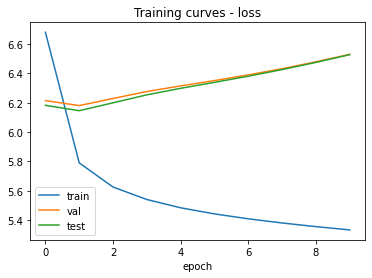

In [31]:
plot_training_curves(training_curves, phases=['train', 'val', 'test'])